Instrucciones:
Si es necesario, estudia el código y el video que explica el uso de Keras para el diseño, entrenamiento y verificación de redes neuronales, los cuales están disponibles como materiales de aprendizaje en este módulo.
Crea un Notebook en Google Colab y sube el dataset que usaste para resolver la detección de peatones con SVM. De preferencia, incorpora el uso de GPU en tu Notebook.
Diseña una red neuronal adecuada para detectar peatones. Toma en cuenta el número de entradas de la red, crea un número adecuado de capas ocultas y crea una capa de salida con una sola neurona con salida binaria.
Si es el caso, reporta como bibliografía otras fuentes de información que consultaste para llegar a la solución.
Crea un video, con una duración menor a dos minutos, en donde expliques los parámetros de la red neuronal y del entrenamiento que permitieron llegar a una solución correcta. Asegúrate de obtener un score de al menos 90%. Sube tu video a tu canal de YouTube y guarda el enlace.
A manera de reporte, crea un documento que incluya tu script con los comentarios y el enlace de tu video en YouTube. Tanto el código como los comentarios son importantes para el documento.

In [18]:
##En esta parte vamos a hacer el import necesario para poder ejecutar el codigo
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
##En este paso vamos a validar si podemos usar GPU o CPU (esto dado que el equipo usa tanto local sin gpy como colab con gpu)
gpus=tf.config.list_logical_devices('GPU')
if gpus:
    print(f"Si hay gpu")
else:
    print("No hay gpu, usando cpu")

No hay gpu, usando cpu


In [3]:
##Aqui agregaremos los parametros necesarios para las funciones, principalmente path e informacion de nuestas imagenes a usar
pedestrian = "./ped"
non_pedestrian = "./non-ped"

image_size = (18, 36)
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (6, 6),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

In [4]:
##Validamos que nuestras imagenes esten el path
#preview images with a function
def preview_images(folder_path, label_name, n=5):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pgm')]
    sample_files = random.sample(image_files, min(n, len(image_files)))

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label_name}\n{filename}\n{img.shape}")
        plt.axis('off')
    plt.suptitle(f"Preview of {label_name} Images")
    plt.tight_layout()
    plt.show()

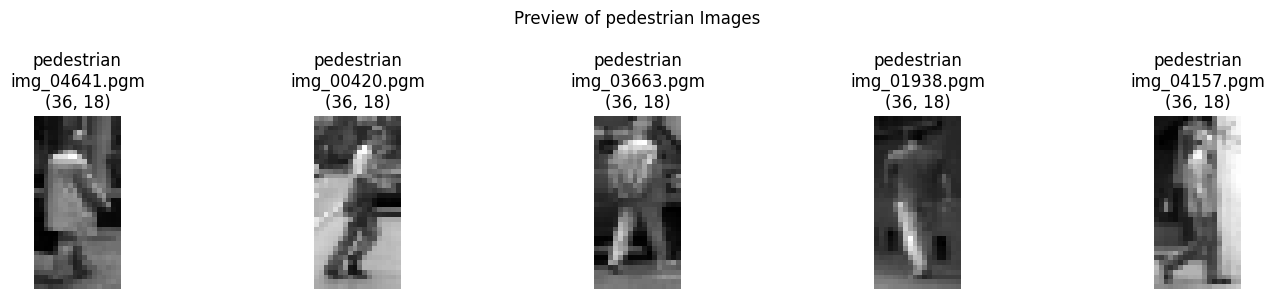

In [5]:
#pedestrian sample
preview_images(pedestrian,'pedestrian')

In [6]:
##FUNCIONES - En esta seccion declararemos las funciones necesarias para la carga y preprosecaiomiento de las imagenes. El objetivo es generar X y Y en formato array pasandolas por un procesamiento de HOG con los parametros usados en la activad anterior.
def load_images(folder_path, label):
    data, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.pgm'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            features = hog(img, **hog_params)
            data.append(features)
            labels.append(label)
    return data, labels

ped_data, ped_labels = load_images(pedestrian, 1)
nonped_data, nonped_labels = load_images(non_pedestrian, 0)

X = np.array(ped_data + nonped_data, dtype=np.float32)
y = np.array(ped_labels + nonped_labels, dtype=np.float32)

In [9]:
##Visualizamos el contenido de X y Y
print(np.info(X))
print(np.info(y))

class:  ndarray
shape:  (9800, 360)
strides:  (1440, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x2a604e07040
byteorder:  little
byteswap:  False
type: float32
None
class:  ndarray
shape:  (9800,)
strides:  (4,)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x2a60399a020
byteorder:  little
byteswap:  False
type: float32
None


In [10]:
##En esta paso vamos a definir nuestra set de entrenamiento y muestra, para esto vamos a hacerlo estratificado 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
##Vamos a definir nuestra Red Neuronal usando Keras, dado proyectos pasados en Deep Learning vamos a partir con un procesamiento secuencial de 2 capas y una capa salida
##La actividad pide una salida binaria por lo cual optamos por usar sigmoid en la capa salida. 
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Salida binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\jhobe\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,529 (213.00 KB)

 Trainable params: 54,529 (213.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
##Con nuestro modelo Keras definido vamos a realizar el proceso de entrenamiento simple, inicaremos solo con 10 epochs, un batch size de 64 y un split de 0.1
##Epoch 10, lo cual indica que el modelo vera el 100% de datos de entrenamiento 10 veces
##batch 64, se crearan mini batches de 64 elementos cada uno , esto para aprovechas gpu en colab
##validation 0.1, esto se define y es arbitrario , se usara el 10% de los datos de entrenamiento para validacion, es bajo para evitar un sobre ajuste. 
##TensorFlow. (2024). Keras model training APIs. Recuperado de https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
##Despues de correrlo algunas veces, vemos que el modelo necesita mas de 10 epochs para aprender mejor. 
entrenamiento = model.fit(X_train, y_train, epochs=12, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9427e-06 - val_accuracy: 0.9719 - val_loss: 0.1397
Epoch 2/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6615e-06 - val_accuracy: 0.9707 - val_loss: 0.1433
Epoch 3/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5931e-06 - val_accuracy: 0.9694 - val_loss: 0.1445
Epoch 4/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4614e-06 - val_accuracy: 0.9719 - val_loss: 0.1429
Epoch 5/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3217e-06 - val_accuracy: 0.9707 - val_loss: 0.1452
Epoch 6/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3374e-06 - val_accuracy: 0.9719 - val_loss: 0.1420
Epoch 7/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2022e-06 - val_accuracy: 0.9719 - val_loss: 0.1439
Epoch 8/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - los

In [17]:
##Despues de un par de ajustes al modelo logramos superar el accuracy del modelo svm por 1%, ahora en esta seccion realizaremos la evluacion del modelo con la data de testeo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9601 - loss: 0.3017
Test Accuracy: 0.9597
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1000
         1.0       0.95      0.97      0.96       960

    accuracy                           0.96      1960
   macro avg       0.96      0.96      0.96      1960
weighted avg       0.96      0.96      0.96      1960

[[949  51]
 [ 28 932]]


              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1000
         1.0       0.95      0.97      0.96       960

    accuracy                           0.96      1960
   macro avg       0.96      0.96      0.96      1960
weighted avg       0.96      0.96      0.96      1960

[[949  51]
 [ 28 932]]


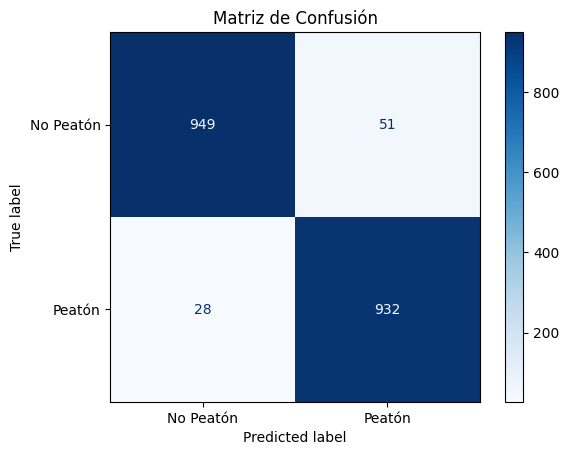

In [19]:
##Aqui visualizamos la matriz de confusion de nuestro modelo. 
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Matriz de confusión gráfica
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Peatón', 'Peatón'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

Conclusiones.
- El modelo tiene un alto desempeño en general, ya que logra un accuracy de 96% 
- Precision , recall y F! son similares por lo cual se puede intuir que no hay sesgos o desbalances significativos entre peaton y no peaton
- Se detectaron 51 no peatones como peatones y 28 peatones como no peatones, lo cual en un ambiente real, sugiere que existirian 28 peatones que realmente no pudieron ser identificados, esto pudiera ser un problema dado que en aplicaciones de la vida real como conduccion autonoma, sugiere que no hubieran podido ser detectados. 
